In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
import sklearn.metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, classification_report,  roc_auc_score, 
accuracy_score, precision_score, recall_score, f1_score, auc, precision_recall_curve, average_precision_score)
from sklearn.ensemble import (RandomForestClassifier)
from sklearn.svm import SVC
import xgboost
from xgboost import XGBClassifier

In [2]:
pd.set_option('display.max_rows', 400)
pd.set_option('max_colwidth', 120)
pd.set_option('display.max_columns', None)

In [12]:
models = {'rf': RandomForestClassifier(random_state=42),
          'xgb': XGBClassifier(seed=42, use_label_encoder=False, eval_metric='auc'),
          'xgb_v1': XGBClassifier(seed=42, use_label_encoder=False, eval_metric='auc'),
          'xgb_v1_03': XGBClassifier(seed=42, use_label_encoder=False, eval_metric='auc')}

c:\Users\kaun9\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [4]:
class CustomTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **transform_params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

# This function takes a dataframe as input and returns a scaled version
def scale_df(input_df):
    ss = StandardScaler()
    feature_names = input_df.columns
    input_df = ss.fit_transform(input_df)
    input_df = pd.DataFrame(input_df, columns=feature_names)
    return input_df

In [5]:
init_list = []
gs_list = []

# Function to run model -- input scaler and model
def run_model(mod, mod_params={}, grid_search=False):
    
    # Initial dictionary to hold model results
    results = {}
    
    pipe = Pipeline([
            ('ss', CustomTransformer(scale_df)),
            (mod, models[mod])
            ])
    if grid_search:
        # Instantiate list to store gridsearch results
        gs = GridSearchCV(pipe, param_grid=mod_params, cv=3, verbose=1, scoring='roc_auc', n_jobs=-1)
        gs.fit(X_train, y_train)
        pipe = gs.best_estimator_
        
    else:
        pipe.fit(X_train, y_train)
    # Retrieve metrics
    predictions = pipe.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    y_test_pred_prob = pipe.predict_proba(X_test)[:,1]
    y_train_pred_prob = pipe.predict_proba(X_train)[:,1]
    
    results['model'] = mod
    results['train_auc'] = roc_auc_score(y_train, y_train_pred_prob)
    results['test_auc'] = roc_auc_score(y_test, y_test_pred_prob)
    results['precision'] = precision_score(y_test, predictions)
    results['specificity'] = tn / (tn + fp)
    results['recall'] = recall_score(y_test, predictions)
    results['f_score'] = f1_score(y_test, predictions)
    
    if grid_search:
        gs_list.append(results)
        print('### BEST PARAMS ###')
        display(pipe[1])
        
    else:
        init_list.append(results)
    
    print('### METRICS ###')
    display(results)
    
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    
    return pipe

In [6]:
def evaluate_model(model):
    final_proba = model.predict_proba(test)
    final_proba = final_proba[:, 1]
    final_preds = model.predict(test)
    print(f'Accuracy:', f'{accuracy_score(final_actual, final_preds):.3f}')
    print(f'Precision:', f'{precision_score(final_actual, final_preds):.3f}')
    print(f'Recall:', f'{recall_score(final_actual, final_preds):.3f}')
    print(f'ROC-AUC:', f'{roc_auc_score(final_actual, final_proba):.3f}')

In [19]:
pd.DataFrame(init_list).sort_values(by='test_auc', ascending=False).reset_index(drop=True)

,model,train_auc,test_auc,precision,specificity,recall,f_score
0,rf,0.999897,0.847301,0.734694,0.917334,0.543624,0.624879


In [ ]:
rf_params = {'rf__n_estimators': [100, 200, 300, 400, 500],
             'rf__max_depth': [10, 20, 30, 40, 50, 60],
             'rf__min_samples_leaf': [i for i in range(2, 18)],
            }
rf_gs =  run_model('rf', mod_params=rf_params, grid_search=True)
#joblib.dump(rf_gs[1], "./model/rf_modified_v1.joblib")

# Random Forest Model


- UNModified Version1<br/>
Choose the first 40 feature with the higher correlation with is_popular

In [20]:
X_graph = []
y_graph = []

In [21]:
train = pd.read_pickle('./feature/feat_v1.pkl')
X = train.drop(columns=['is_popular','n_comment','group_by_subsection_name','feature_subsection_name'])
y = train['is_popular']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_graph.append(X_test)
y_graph.append(y_test)
feature_names = X_train.columns

rf_v1 = run_model('rf')
rf_v1_param = { 
              'rf__n_estimators': [300],
             'rf__max_depth': [20],
             'rf__min_samples_leaf': [2],
            }
rf_gs_v1 = run_model('rf', mod_params=rf_v1_param, grid_search=True)
test = pd.read_pickle('./feature/feat_test_v1.pkl')
test = test._get_numeric_data()

final_actual = test['is_popular']
test = test.drop(columns=['is_popular'])
test = test.drop(columns=['feature_subsection_name'])
test = test.drop(columns=['n_comment'])
test = test.drop(columns=['group_by_subsection_name'])

evaluate_model(rf_gs_v1)
rf_gs_v1.fit(X, y)
print(' ')
evaluate_model(rf_gs_v1)

### METRICS ###


{'model': 'rf',
 'train_auc': 0.9999999648146146,
 'test_auc': 0.8861427964945664,
 'precision': 0.757903324495207,
 'specificity': 0.9088535667664901,
 'recall': 0.6249579549276825,
 'f_score': 0.6850400958613697}

True Negatives: 11836
False Positives: 1187
False Negatives: 2230
True Positives: 3716
Fitting 3 folds for each of 1 candidates, totalling 3 fits
### BEST PARAMS ###


RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=300,
                       random_state=42)

### METRICS ###


{'model': 'rf',
 'train_auc': 0.9945258882383992,
 'test_auc': 0.8893295178891113,
 'precision': 0.7667644593461861,
 'specificity': 0.9145358212393457,
 'recall': 0.6153716784392869,
 'f_score': 0.6827766374323568}

True Negatives: 11910
False Positives: 1113
False Negatives: 2287
True Positives: 3659
Accuracy: 0.806
Precision: 0.761
Recall: 0.566
ROC-AUC: 0.879
 
Accuracy: 0.810
Precision: 0.772
Recall: 0.568
ROC-AUC: 0.882


- wrong predict analysis<br/>

In [33]:
final_proba = rf_gs_v1.predict_proba(test)
final_proba = final_proba[:, 1]
final_preds = rf_gs_v1.predict(test)
predictions = pd.DataFrame(data=[final_actual, final_preds, final_proba]).T
predictions.columns = ['actual', 'predicted', 'proba']
predictions
wrong_predictions = predictions[predictions['actual'] != predictions['predicted']]
init_test = pd.read_pickle('./dataset/test.pkl').reset_index(drop=True)
wrong_predictions = pd.merge(wrong_predictions, init_test, left_index=True, right_index=True)
wrong_predictions = wrong_predictions[['actual', 'predicted', 'proba', 'news_desk', 'section_name', 'subsection_name',
                                       'headline', 'abstract', 'keywords']]
# 1 = false positives, 0 = false negatives
wrong_predictions['actual'].value_counts()
wrong_predictions[wrong_predictions['proba'] > 0.80].head(10).sort_values(by='proba', ascending=False)


,actual,predicted,proba,news_desk,section_name,subsection_name,headline,abstract,keywords
397,0.0,1.0,0.934727,Well,Well,Live,Why Are We So Afraid of Fevers?,"Under most circumstances, fever is beneficial, reducing the severity of illness and shortening its length.","[Fever, Temperature, Seizures (Medical), Immune System, Infections, College of Physicians of Philadelphia]"
476,0.0,1.0,0.882287,RealEstate,Real Estate,NaN,The ‘Posh Portals’ of New York City,A new book looks at how grand entrances have helped define some of the city’s most exclusive apartment houses.,"[Real Estate and Housing (Residential), Historic Buildings and Sites, Stern, Robert AM, Architects LLP, Dakota (Manh..."
18,0.0,1.0,0.876293,RealEstate,Real Estate,NaN,Top Sales Show How Pandemic Continues to Influence the Market,Single-family houses and penthouses remained in demand in December as buyers sought out homes with more personal space.,"[Real Estate and Housing (Residential), High Net Worth Individuals, Coronavirus (2019-nCoV), One57 (Manhattan, NY, A..."
401,0.0,1.0,0.872928,Travel,Travel,NaN,"A Long, Lonesome Look at America","Alone on a 10,000-mile road trip across the United States, a Times journalist found an America cloaked in solitude —...","[Road Trips, Forests and Forestry, Quarantine (Life and Culture), United States]"
109,0.0,1.0,0.859896,OpEd,Opinion,NaN,"To Defend Democracy, Investigate Trump",There needs to be a cost to trying to overthrow an election.,"[Trump, Donald J, Presidential Election of 2020, Voting and Voters, Georgia, Voter Fraud (Election Fraud), Corruptio..."
469,0.0,1.0,0.842519,Learning,The Learning Network,NaN,Teaching With the ‘My Ten’ Column,"In this Times feature, celebrities share 10 cultural items they can’t live without. In this lesson, we invite studen...",[]
106,0.0,1.0,0.838159,OpEd,Opinion,NaN,How the Republican Party Went Feral,Democracy is now threatened by malevolent tribalism.,"[United States Politics and Government, Frauds and Swindling, Republican Party, Trump, Donald J, Loeffler, Kelly L, ..."
399,0.0,1.0,0.813793,RealEstate,Real Estate,NaN,Shopping for Kettles,It’s not just for boiling water — so choose something with a little style.,"[Design, Tableware, Kitchens, Tea, Home Appliances]"
486,0.0,1.0,0.810590,Dining,Food,NaN,"At New York Restaurants, It’s the Season of the Yurt","Single-table huts, cabins and bubbles have sprung up across the city. A safer or more pleasant way to eat outdoors? ...","[Restaurants, Tents, Quarantine (Life and Culture), New York City]"
117,0.0,1.0,0.808919,RealEstate,Real Estate,NaN,New York Real Estate Begins Its Recovery,"Real estate sales picked up in the final months of 2020, but not enough to make up for the shutdown in the early mon...","[Real Estate and Housing (Residential), Quarantine (Life and Culture), Manhattan (NYC)]"


In [32]:
wrong_predictions[wrong_predictions['proba'] < 0.4].head(10).sort_values(by='proba')

,actual,predicted,proba,news_desk,section_name,subsection_name,headline,abstract,keywords
111,1.0,0.0,0.005000,Summary,Today’s Paper,NaN,Quotation of the Day: Campaigns Chase Next Power Base: Georgia’s Young,"Quotation of the Day for Tuesday, January 5, 2021.",[]
129,1.0,0.0,0.010804,NYTNow,Briefing,NaN,Georgia Votes,And what else you need to know today.,[]
61,1.0,0.0,0.193583,Business,Business Day,Media,They Seem to Think the Next Four Years Will Be Normal,A Beltway school of journalism wants to get back to just-the-facts-ma’am reporting. But how do you cover this Republ...,"[News and News Media, United States Politics and Government, Presidential Election of 2020, Newsletters, Start-ups, ..."
99,1.0,0.0,0.216211,Culture,Movies,NaN,Listen to Rudolph: A New Year Is Both a Comfort and a Fiction,A 1976 TV movie that imagined years as people is a helpful reminder that a new page on the calendar is an arbitrary ...,"[New Year, Movies, Rudolph's Shiny New Year (Movie), Rankin-Bass Productions, Television, Two Thousand Twenty]"
38,1.0,0.0,0.232003,OpEd,Opinion,NaN,Do Children Really Need to Learn to Code?,"In India, parents are being aggressively sold the idea that their children must start coding at 4 or 5 or be future ...","[Quarantine (Life and Culture), E-Learning, Children and Childhood, Education (K-12), Parenting, India, Computers an..."
112,1.0,0.0,0.282269,Dining,Food,NaN,"Spanish Seafood, Grilled and Tinned","The chef Abel Álvarez’s Conservas Braseadas Güeyumar seafood line features grilled cockles, razor clams and tuna nec...","[Seafood, Cooking and Cookbooks]"
121,1.0,0.0,0.309820,BookReview,Books,Book Review,Hate Working Out? Blame Evolution,Daniel Lieberman’s “Exercised” looks at evolutionary biology to explain what might be the most appropriate workout r...,"[Books and Literature, Exercise, Lieberman, Daniel E, Exercised: Why Something We Never Evolved to Do Is Healthy and..."
80,1.0,0.0,0.321227,The Upshot,The Upshot,NaN,Election Day Voting in 2020 Took Longer in America’s Poorest Neighborhoods,An analysis of voting times based on anonymous smartphone location data.,"[Voting and Voters, United States Politics and Government, Presidential Election of 2020, Research, Minorities]"
123,1.0,0.0,0.364809,Styles,Style,NaN,"Paring Back Your Beauty Routine? Try Water, With a Boost",Hydration is trending. It’s the latest lucrative frontier of the wellness boom.,"[Skin, Water, Lemons, Content Type: Service]"
62,1.0,0.0,0.380507,OpEd,Opinion,NaN,The Holocaust Stole My Youth. Covid-19 Is Stealing My Last Years.,A Holocaust survivor reflects on what it means to survive the pandemic.,"[Holocaust and the Nazi Era, Coronavirus (2019-nCoV), Content Type: Personal Profile, Jews and Judaism, Elderly, Gra..."


- true predict analysis<br/>

In [34]:
predictions = pd.merge(predictions, init_test, left_index=True, right_index=True)
predictions = predictions[['actual', 'predicted', 'proba', 'news_desk', 'section_name', 'subsection_name',
                                       'headline', 'abstract', 'keywords']]
predictions.sort_values(by='proba', ascending=False).head(5)

,actual,predicted,proba,news_desk,section_name,subsection_name,headline,abstract,keywords
22974,0.0,1.0,0.999899,Games,Crosswords & Games,NaN,Write on Stone,Go on a journey with Michael Schlossberg’s Monday puzzle.,"[Crossword Puzzles, Schlossberg, Michael (Crossword Constructor)]"
28761,1.0,1.0,0.999846,Games,Crosswords & Games,NaN,"Snap, Crackle and Pop",Joe Rodini’s debut puzzle takes solvers on a tour.,[Crossword Puzzles]
4122,0.0,1.0,0.999696,Games,Crosswords & Games,NaN,Climber in Academia,"Alex Rosen and Brad Wilber bring out the entertainers, one by one.",[Crossword Puzzles]
26995,0.0,1.0,0.999270,Games,Crosswords & Games,NaN,Parenthetical Comment,Michael Lieberman’s puzzle goes above and beyond-a.,"[Crossword Puzzles, Lieberman, Michael (Crossword Constructor)]"
23521,0.0,1.0,0.998875,Games,Crosswords & Games,NaN,Diary of a Spelling Bee Fanatic,"Entries for the week of June 13, 2022.",[Spelling Bee (Game)]


In [35]:
predictions.sort_values(by='proba', ascending=False).tail(5)

,actual,predicted,proba,news_desk,section_name,subsection_name,headline,abstract,keywords
18207,0.0,0.0,0.0,Letters,Opinion,Letters,How Should Biden Deal With Russia on Ukraine?,Readers differ on how President Biden is handling the Ukraine crisis. Also: The Canadian truckers’ protest; Liz Chen...,"[Biden, Joseph R Jr, Putin, Vladimir V, Russia, Ukraine, United States Politics and Government, United States Defens..."
14253,0.0,0.0,0.0,NYTNow,Briefing,NaN,"Inflation, Kyle Rittenhouse, ‘Chicago’: Your Wednesday Evening Briefing",Here’s what you need to know at the end of the day.,[]
14261,1.0,0.0,0.0,NYTNow,Briefing,NaN,Your Thursday Briefing,Crisis at the E.U. border.,[]
22975,0.0,0.0,0.0,NYTNow,Briefing,NaN,Your Monday Briefing,Britain’s Jubilee celebrations.,[]
24808,0.0,0.0,0.0,Corrections,Corrections,NaN,"Corrections: July 19, 2022","Corrections that appeared in print on Tuesday, July 19, 2022.",[]


- feature importance<br/>

<Axes: >

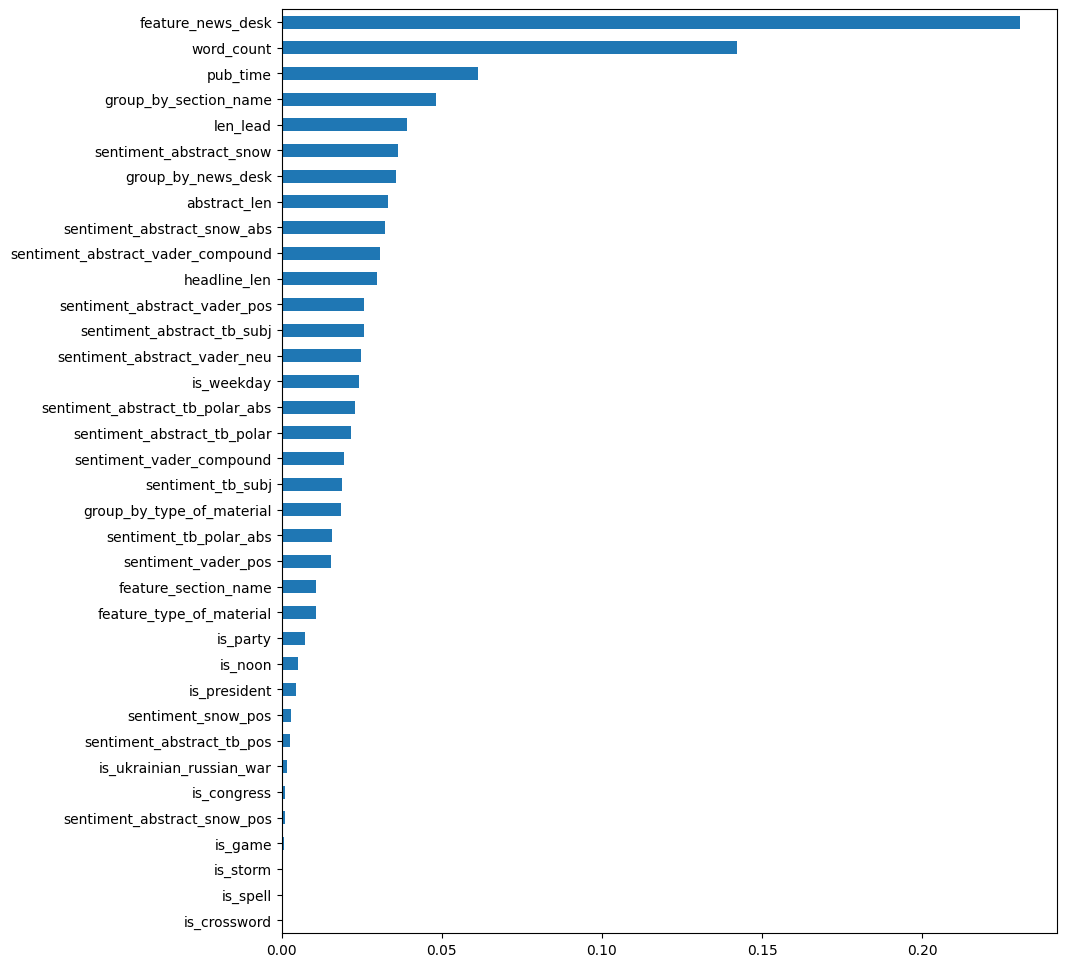

In [36]:
plt.figure(figsize=(10,12))
rf_feature_imp = pd.Series(rf_gs_v1[1][1].feature_importances_, index=X.columns).sort_values(ascending=False)
rf_feature_imp.sort_values().plot(kind = 'barh')

- UNModified Version2<br/>
The dataset has 30% is_popular data, as same as the modified dataset.

In [ ]:
train = pd.read_pickle('./feature/feat_v2.pkl')
X = train.drop(columns=['is_popular','n_comment','group_by_subsection_name','feature_subsection_name'])
y = train['is_popular']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_graph.append(X_test)
y_graph.append(y_test)
feature_names = X_train.columns

rf_v2 = run_model('rf')
rf_v2_param = { 
              'rf__n_estimators': [300],
             'rf__max_depth': [25],
             'rf__min_samples_leaf': [2],
            }
rf_gs_v2 = run_model('rf', mod_params=rf_v2_param, grid_search=True)
test = pd.read_pickle('./feature/feat_test_v2.pkl')
test = test._get_numeric_data()

final_actual = test['is_popular']
test = test.drop(columns=['is_popular'])
test = test.drop(columns=['feature_subsection_name'])
test = test.drop(columns=['n_comment'])
test = test.drop(columns=['group_by_subsection_name'])

evaluate_model(rf_gs_v2)
rf_gs_v2.fit(X, y)
print(' ')
evaluate_model(rf_gs_v2)

- Modified Version1<br/>
Choose the first 40 feature with the higher correlation with is_popular

In [16]:
train = pd.read_pickle('./feature/feat_modified_v1.pkl')
X = train.drop(columns=['is_popular','n_comment','group_by_subsection_name','feature_subsection_name'])
y = train['is_popular']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_graph.append(X_test)
y_graph.append(y_test)
feature_names = X_train.columns

rf_mod_v1 = run_model('rf')
rf_mod_v1_param = { 
              'rf__n_estimators': [300],
             'rf__max_depth': [15],
             'rf__min_samples_leaf': [7],
            }
rf_gs_mod_v1 = run_model('rf', mod_params=rf_mod_v1_param, grid_search=True)
test = pd.read_pickle('./feature/feat_test_modified_v1.pkl')
test = test._get_numeric_data()

final_actual = test['is_popular']
test = test.drop(columns=['is_popular'])
test = test.drop(columns=['feature_subsection_name'])
test = test.drop(columns=['n_comment'])
test = test.drop(columns=['group_by_subsection_name'])

evaluate_model(rf_gs_mod_v1)
rf_gs_mod_v1.fit(X, y)
print(' ')
evaluate_model(rf_gs_mod_v1)

### METRICS ###


{'model': 'rf',
 'train_auc': 0.9999143583927594,
 'test_auc': 0.8459441627387693,
 'precision': 0.7375669472073451,
 'specificity': 0.91921808761187,
 'recall': 0.5391498881431768,
 'f_score': 0.6229402261712439}

True Negatives: 3903
False Positives: 343
False Negatives: 824
True Positives: 964
Fitting 3 folds for each of 1 candidates, totalling 3 fits
### BEST PARAMS ###


RandomForestClassifier(max_depth=15, min_samples_leaf=7, n_estimators=300,
                       random_state=42)

### METRICS ###


{'model': 'rf',
 'train_auc': 0.9427084962223582,
 'test_auc': 0.8512702704269105,
 'precision': 0.7505863956215794,
 'specificity': 0.9248704663212435,
 'recall': 0.5369127516778524,
 'f_score': 0.6260189109879362}

True Negatives: 3927
False Positives: 319
False Negatives: 828
True Positives: 960
Accuracy: 0.675
Precision: 0.889
Recall: 0.400
ROC-AUC: 0.827
 
Accuracy: 0.676
Precision: 0.897
Recall: 0.396
ROC-AUC: 0.827


- Modified Version1.03<br/>

In [17]:
train = pd.read_pickle('./feature/feat_modified_v1_0.3.pkl')
X = train.drop(columns=['is_popular','n_comment','group_by_subsection_name','feature_subsection_name'])
y = train['is_popular']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_graph.append(X_test)
y_graph.append(y_test)
feature_names = X_train.columns

rf_mod_v1_03 = run_model('rf')
rf_mod_v1_03_param = { 
              'rf__n_estimators': [300],
             'rf__max_depth': [20],
             'rf__min_samples_leaf': [6],
            }
rf_gs_mod_v1_03 = run_model('rf', mod_params=rf_mod_v1_03_param, grid_search=True)
test = pd.read_pickle('./feature/feat_test_modified_v1_0.3.pkl')
test = test._get_numeric_data()

final_actual = test['is_popular']
test = test.drop(columns=['is_popular'])
test = test.drop(columns=['feature_subsection_name'])
test = test.drop(columns=['n_comment'])
test = test.drop(columns=['group_by_subsection_name'])

evaluate_model(rf_gs_mod_v1_03)
rf_gs_mod_v1_03.fit(X, y)
print(' ')
evaluate_model(rf_gs_mod_v1_03)

### METRICS ###


{'model': 'rf',
 'train_auc': 0.9998967887426946,
 'test_auc': 0.8473006835753296,
 'precision': 0.7346938775510204,
 'specificity': 0.9173339613754121,
 'recall': 0.5436241610738255,
 'f_score': 0.6248794599807136}

True Negatives: 3895
False Positives: 351
False Negatives: 816
True Positives: 972
Fitting 3 folds for each of 1 candidates, totalling 3 fits
### BEST PARAMS ###


RandomForestClassifier(max_depth=20, min_samples_leaf=6, n_estimators=300,
                       random_state=42)

### METRICS ###


{'model': 'rf',
 'train_auc': 0.9648102452744619,
 'test_auc': 0.8537037359019832,
 'precision': 0.7452326468344775,
 'specificity': 0.9213377296278851,
 'recall': 0.546420581655481,
 'f_score': 0.6305259761213294}

True Negatives: 3912
False Positives: 334
False Negatives: 811
True Positives: 977
Accuracy: 0.678
Precision: 0.886
Recall: 0.408
ROC-AUC: 0.827
 
Accuracy: 0.676
Precision: 0.892
Recall: 0.398
ROC-AUC: 0.827


- Modified Version2<br/>

In [ ]:
train = pd.read_pickle('./feature/feat_modified_v2.pkl')
X = train.drop(columns=['is_popular','n_comment','group_by_subsection_name','feature_subsection_name'])
y = train['is_popular']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_graph.append(X_test)
y_graph.append(y_test)
feature_names = X_train.columns

rf_mod_v2 = run_model('rf')
rf_mod_v2_param = { 
              'rf__n_estimators': [300],
             'rf__max_depth': [15],
             'rf__min_samples_leaf': [1],
            }
rf_gs_mod_v2 = run_model('rf', mod_params=rf_mod_v2_param, grid_search=True)
test = pd.read_pickle('./feature/feat_test_modified_v2.pkl')
test = test._get_numeric_data()

final_actual = test['is_popular']
test = test.drop(columns=['is_popular'])
test = test.drop(columns=['feature_subsection_name'])
test = test.drop(columns=['n_comment'])
test = test.drop(columns=['group_by_subsection_name'])

evaluate_model(rf_gs_mod_v2)
rf_gs_mod_v2.fit(X, y)
print(' ')
evaluate_model(rf_gs_mod_v2)

# XGBoost Model

- Unmodified Version1

In [ ]:
train = pd.read_pickle('./feature/feat_v1.pkl')
X = train.drop(columns=['is_popular','n_comment','group_by_subsection_name','feature_subsection_name'])
y = train['is_popular']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_graph.append(X_test)
y_graph.append(y_test)
feature_names = X_train.columns

xgb = run_model('xgb')
xgb_v1_param = { 
              'xgb__learning_rate' : [0.1], 
              'xgb__max_depth' : [5],
              'xgb__n_estimators' : [300], 
              'xgb__reg_alpha' : [1.0], 
              'xgb__reg_lambda' : [1.0], 
              'xgb__gamma' : [2.5],
            }
xgb_gs_v1 = run_model('xgb', mod_params=xgb_v1_param, grid_search=True)
test = pd.read_pickle('./feature/feat_test_v1.pkl')
test = test._get_numeric_data()

final_actual = test['is_popular']
test = test.drop(columns=['is_popular'])
test = test.drop(columns=['feature_subsection_name'])
test = test.drop(columns=['n_comment'])
test = test.drop(columns=['group_by_subsection_name'])

evaluate_model(xgb_gs_v1)
xgb_gs_v1.fit(X, y)
print(' ')
evaluate_model(xgb_gs_v1)

- Unmodified Version2

In [ ]:
train = pd.read_pickle('./feature/feat_v2.pkl')
X = train.drop(columns=['is_popular'])
y = train['is_popular']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_graph.append(X_test)
y_graph.append(y_test)
feature_names = X_train.columns

xgb = run_model('xgb')
xgb_params = { 
              'xgb__learning_rate' : [0.1, 0.2, 0.3], 
              'xgb__max_depth' : [3, 5], 
              'xgb__n_estimators' : [100, 200, 300], 
              'xgb__reg_alpha' : [0.1, 1.0, 1.8, 2.0], 
              'xgb__reg_lambda' : [0.1, 1.0, 2.0, 2.4, 3.0], 
              'xgb__gamma' : [1.0, 2.0, 2.5, 3.0], 
            }
xgb_v2_param = { 
              'xgb__learning_rate' : [0.1], 
              'xgb__max_depth' : [5], 
              'xgb__n_estimators' : [300], 
              'xgb__reg_alpha' : [1.0], 
              'xgb__reg_lambda' : [3.0], 
              'xgb__gamma' : [2.0], 
            }
xgb_gs_v2 = run_model('xgb', mod_params=xgb_v2_param, grid_search=True)
#xgb_gs[1].save_model('./model/xgb_v2.json')
test = pd.read_pickle('./feature/feat_test_v2.pkl')
test = test._get_numeric_data()
final_actual = test['is_popular']
test = test.drop(columns=['is_popular'])
test = test.drop(columns=['feature_subsection_name'])
test = test.drop(columns=['n_comment'])
test = test.drop(columns=['group_by_subsection_name'])

evaluate_model(xgb_gs_v2)
xgb_gs_v2.fit(X, y)
print(' ')
evaluate_model(xgb_gs_v2)

- Modified Version1<br/>
Choose the first 40 feature with the higher correlation with is_popular

In [56]:
train = pd.read_pickle('./feature/feat_modified_v1.pkl')
X = train.drop(columns=['is_popular','n_comment','group_by_subsection_name','feature_subsection_name'])
y = train['is_popular']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_graph.append(X_test)
y_graph.append(y_test)
feature_names = X_train.columns

xgb_mod_v1 = run_model('xgb')
xgb_mod_v1_param = { 
              'xgb__learning_rate' : [0.1], 
              'xgb__max_depth' : [5],
              'xgb__n_estimators' : [100], 
              'xgb__reg_alpha' : [1.8], 
              'xgb__reg_lambda' : [3.0], 
              'xgb__gamma' : [1.0],
            }
xgb_gs_mod_v1 = run_model('xgb', mod_params=xgb_mod_v1_param, grid_search=True)
test = pd.read_pickle('./feature/feat_test_modified_v1.pkl')
test = test._get_numeric_data()

final_actual = test['is_popular']
test = test.drop(columns=['is_popular'])
test = test.drop(columns=['feature_subsection_name'])
test = test.drop(columns=['n_comment'])
test = test.drop(columns=['group_by_subsection_name'])

evaluate_model(xgb_gs_mod_v1)
xgb_gs_mod_v1.fit(X, y)
print(' ')
evaluate_model(xgb_gs_mod_v1)


### METRICS ###


{'model': 'xgb',
 'train_auc': 0.9750533631900492,
 'test_auc': 0.8394286871918404,
 'precision': 0.7098214285714286,
 'specificity': 0.9081488459726802,
 'recall': 0.5335570469798657,
 'f_score': 0.6091954022988506}

True Negatives: 3856
False Positives: 390
False Negatives: 834
True Positives: 954
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\88690\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\88690\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


### BEST PARAMS ###


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=1.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### METRICS ###


{'model': 'xgb',
 'train_auc': 0.8957814876576966,
 'test_auc': 0.8495945256016716,
 'precision': 0.7450826121164438,
 'specificity': 0.9236928874234573,
 'recall': 0.5296420581655481,
 'f_score': 0.6191565871199739}

True Negatives: 3922
False Positives: 324
False Negatives: 841
True Positives: 947
Accuracy: 0.675
Precision: 0.899
Recall: 0.393
ROC-AUC: 0.823
 
Accuracy: 0.679
Precision: 0.898
Recall: 0.403
ROC-AUC: 0.826


- Modified Version1.03</br>
The dataset has 30% is_popular data, as same as the unmodified dataset.

In [57]:
train = pd.read_pickle('./feature/feat_modified_v1_0.3.pkl')
X = train.drop(columns=['is_popular','n_comment','group_by_subsection_name','feature_subsection_name'])
y = train['is_popular']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_graph.append(X_test)
y_graph.append(y_test)
feature_names = X_train.columns

xgb_mod_v1_03 = run_model('xgb')
xgb_mod_v1_03_param = { 
              'xgb__learning_rate' : [0.1], 
              'xgb__max_depth' : [5],
              'xgb__n_estimators' : [200], 
              'xgb__reg_alpha' : [1.8], 
              'xgb__reg_lambda' : [0.1], 
              'xgb__gamma' : [3.0],
            }
xgb_gs_mod_v1_03 = run_model('xgb', mod_params=xgb_mod_v1_03_param, grid_search=True)

test = pd.read_pickle('./feature/feat_test_modified_v1_0.3.pkl')
test = test._get_numeric_data()

final_actual = test['is_popular']
test = test.drop(columns=['is_popular'])
test = test.drop(columns=['feature_subsection_name'])
test = test.drop(columns=['n_comment'])
test = test.drop(columns=['group_by_subsection_name'])

evaluate_model(xgb_gs_mod_v1_03)
xgb_gs_mod_v1_03.fit(X, y)
print(' ')
evaluate_model(xgb_gs_mod_v1_03)


### METRICS ###


{'model': 'xgb',
 'train_auc': 0.9812659580551263,
 'test_auc': 0.8361775683601674,
 'precision': 0.7004437869822485,
 'specificity': 0.9046161092793217,
 'recall': 0.5296420581655481,
 'f_score': 0.6031847133757963}

True Negatives: 3841
False Positives: 405
False Negatives: 841
True Positives: 947
Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\88690\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\88690\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


### BEST PARAMS ###


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=3.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### METRICS ###


{'model': 'xgb',
 'train_auc': 0.9078018478405325,
 'test_auc': 0.8514977512721541,
 'precision': 0.7408844065166796,
 'specificity': 0.9213377296278851,
 'recall': 0.5341163310961968,
 'f_score': 0.620734481637959}

True Negatives: 3912
False Positives: 334
False Negatives: 833
True Positives: 955
Accuracy: 0.680
Precision: 0.900
Recall: 0.405
ROC-AUC: 0.827
 
Accuracy: 0.682
Precision: 0.902
Recall: 0.406
ROC-AUC: 0.826


- Modified Version2

In [62]:
train = pd.read_pickle('./feature/feat_modified_v2.pkl')
X = train.drop(columns=['is_popular'])
y = train['is_popular']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_graph.append(X_test)
y_graph.append(y_test)
feature_names = X_train.columns

xgb_mod_v2 = run_model('xgb')
xgb_params = { 
              'xgb__learning_rate' : [0.1], 
              'xgb__max_depth' : [5], 
              'xgb__n_estimators' : [300], 
              'xgb__reg_alpha' : [1.0], 
              'xgb__reg_lambda' : [3.0], 
              'xgb__gamma' : [2.0], 
            }
xgb_gs_mod_v2 = run_model('xgb', mod_params=xgb_params, grid_search=True)
xgb_gs_mod_v2[1].save_model('./model/xgb_modified_v2.json')

test = pd.read_pickle('./feature/feat_test_modified_v2.pkl')
test = test._get_numeric_data()

final_actual = test['is_popular']
test = test.drop(columns=['is_popular'])
test = test.drop(columns=['feature_subsection_name'])
test = test.drop(columns=['n_comment'])
test = test.drop(columns=['group_by_subsection_name'])

evaluate_model(xgb_gs_mod_v2)
xgb_gs_mod_v2.fit(X, y)
print(' ')
evaluate_model(xgb_gs_mod_v2)


### METRICS ###


{'model': 'xgb',
 'train_auc': 0.9745069257540302,
 'test_auc': 0.833544544487334,
 'precision': 0.7451388888888889,
 'specificity': 0.7616883116883116,
 'recall': 0.7264725795531483,
 'f_score': 0.7356873500171409}

True Negatives: 2346
False Positives: 734
False Negatives: 808
True Positives: 2146
Fitting 3 folds for each of 1440 candidates, totalling 4320 fits


c:\Users\88690\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\88690\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


### BEST PARAMS ###


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=3.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### METRICS ###


{'model': 'xgb',
 'train_auc': 0.900992668503653,
 'test_auc': 0.8415897110675377,
 'precision': 0.7680262199563,
 'specificity': 0.7931818181818182,
 'recall': 0.7139471902505078,
 'f_score': 0.7400000000000001}

True Negatives: 2443
False Positives: 637
False Negatives: 845
True Positives: 2109


"\ntest = pd.read_pickle('./feature/feat_test_modified_v2.pkl')\ntest = test._get_numeric_data()\n\nfinal_actual = test['is_popular']\ntest = test.drop(columns=['is_popular'])\ntest = test.drop(columns=['feature_subsection_name'])\ntest = test.drop(columns=['n_comment'])\ntest = test.drop(columns=['group_by_subsection_name'])\n\nevaluate_model(xgb_gs_mod_v2)\nxgb_gs_mod_v2.fit(X, y)\nprint(' ')\nevaluate_model(xgb_gs_mod_v2)"

In [70]:

xgb_params = { 
              'xgb__learning_rate' : [0.1, 0.2, 0.3], 
              'xgb__max_depth' : [3, 5], 
              'xgb__n_estimators' : [100, 200, 300], 
              'xgb__reg_alpha' : [0.1, 1.0, 1.8, 2.0], 
              'xgb__reg_lambda' : [0.1, 1.0, 2.0, 2.4, 3.0], 
              'xgb__gamma' : [1.0, 2.0, 2.5, 3.0], 
            }
xgb_gs = run_model('xgb', mod_params=xgb_params, grid_search=True)
xgb_gs[1].save_model('./model/xgb_modified_v2.json')

c:\Users\88690\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\88690\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Fitting 3 folds for each of 1 candidates, totalling 3 fits
### BEST PARAMS ###


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=3.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### METRICS ###


{'model': 'xgb',
 'train_auc': 0.9078018478405325,
 'test_auc': 0.8514977512721541,
 'precision': 0.7408844065166796,
 'specificity': 0.9213377296278851,
 'recall': 0.5341163310961968,
 'f_score': 0.620734481637959}

True Negatives: 3912
False Positives: 334
False Negatives: 833
True Positives: 955


In [40]:
gs_df = pd.DataFrame(gs_list)
gs_df.sort_values(by='test_auc', ascending=False)

,model,train_auc,test_auc,precision,specificity,recall,f_score
1,xgb,0.907802,0.851498,0.740884,0.921338,0.534116,0.620734
0,xgb,0.895781,0.849595,0.745083,0.923693,0.529642,0.619157


In [58]:
gs_dict = {
    rf_gs_v1: 'RandomForest Unmodified V1',
    rf_gs_v2: 'RandomForest Unmodified V2',
    rf_gs_mod_v1: 'RandomForest Modified V1',
    rf_gs_mod_v1_03: 'RandomForest Modified V1-0.3',
    rf_gs_mod_v2: 'RandomForest Modified V2',
    xgb_gs_v1: 'XGBoostClassfier Unmodified V1',
    xgb_gs_v2: 'XGBoostClassfier Unmodified V2',
    xgb_gs_mod_v1: 'XGBoostClassfier Modified V1',
    xgb_gs_mod_v1_03: 'XGBoostClassfier Modified V1-0.3',
    xgb_gs_mod_v2: 'XGBoostClassfier Modified V2',
}

In [60]:
def roc_curve_plotter(model_dict, plot_top=False):
    fig, ax = plt.subplots(1, 1, figsize=(12,10))
    axes = {}
    for i, m in enumerate(model_dict.keys()):
        axes[f'ax{i}'] = sklearn.metrics.RocCurveDisplay.from_estimator(m, X_graph[i], y_graph[i], ax=ax, name=model_dict[m])
    if plot_top:
        for i, a in enumerate(axes):
            if i != 0:
                axes[a].line_.set_color('gray')
                axes[a].line_.set_alpha(0.25)
                
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')
    plt.title('ROC-AUC Curve', fontsize=22)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend(fontsize=12)

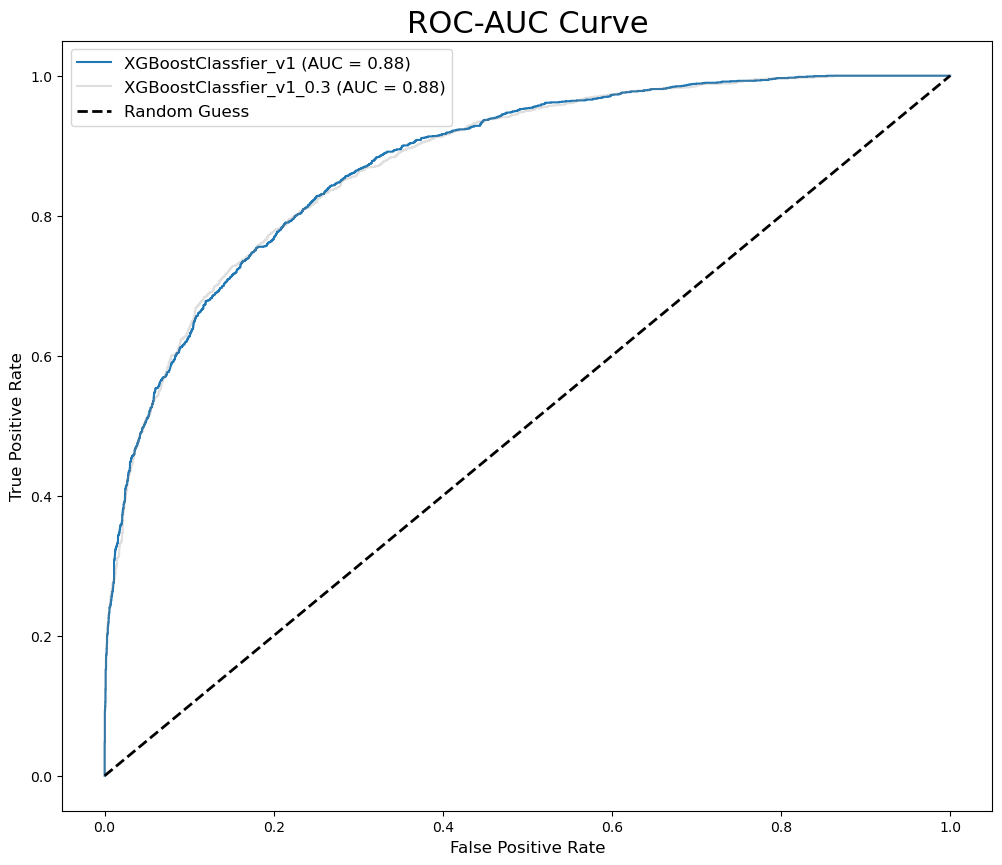

In [61]:
roc_curve_plotter(gs_dict, True)